In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
engine.table_names()

['measurement', 'station']

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

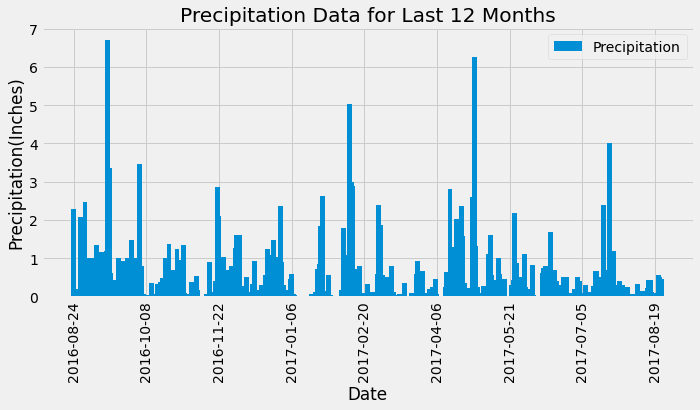

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Query for the dates in measurement table and list them in descending order to find the last date of recorded data
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Create reference to last date and separate date into day, month and year elements
last_date = [int(last_date[0][:4]), int(last_date[0][5:7]), int(last_date[0][8:])]
# Calculate the date 1 year from the last date
year_ago = dt.date(last_date[0], last_date[1], last_date[2]) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
prcp_data = session.query(*sel).filter(Measurement.date > year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
dates = list(df.index.values)
precipitation = df['Precipitation']

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(dates, precipitation, width=3)

# Reduce number of x ticks
ticks = ax.get_xticks()
n = len(ticks)//8
ax.set_xticks(ticks[::n])

# Set axis and title labels, add legend and rotate x tick labels
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation(Inches)")
ax.set_title("Precipitation Data for Last 12 Months")
fig.tight_layout()
plt.xticks(rotation=90)
plt.legend(['Precipitation'])

plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = df.describe()
summary_stats


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
station_count

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, Station.name, func.count(Measurement.station)).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = stations[0][0]

lowest_temp = session.query(func.min(Measurement.tobs)).filter_by(station = most_active_station).first()
highest_temp = session.query(func.max(Measurement.tobs)).filter_by(station = most_active_station).first()
avg_temp = session.query(func.round(func.avg(Measurement.tobs),2)).filter_by(station = most_active_station).first()

print(f'The lowest recorded temperature is {lowest_temp[0]} degrees Fahrenheit.')
print(f'The highest recorded temperature is {highest_temp[0]} degrees Fahrenheit.')
print(f'The average temperature is {avg_temp[0]} degrees Fahrenheit.')

The lowest recorded temperature is 54.0 degrees Fahrenheit.
The highest recorded temperature is 85.0 degrees Fahrenheit.
The average temperature is 71.66 degrees Fahrenheit.


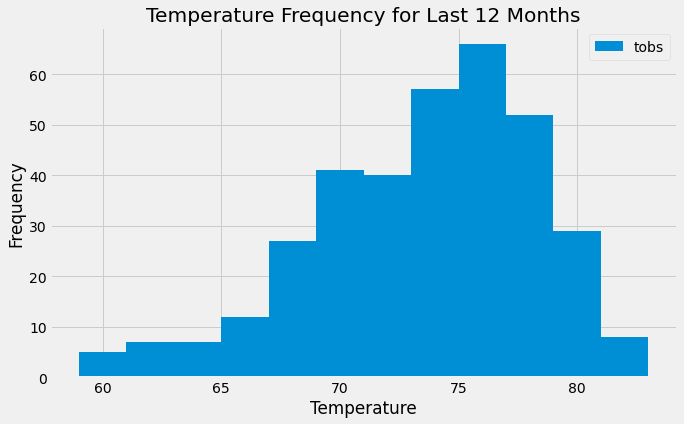

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temps = session.query(Measurement.date, Measurement.tobs).\
    filter_by(station = most_active_station).\
    filter(Measurement.date > year_ago).all()

# Create a dataframe using the results from above query
temps_df = pd.DataFrame(last_year_temps)

# Set values and plot histogram with 12 bins
values = temps_df['tobs']

hist = values.hist(bins=12, figsize=(10,6))

# Add labels and legend to plot
hist.set_title('Temperature Frequency for Last 12 Months')
hist.set_xlabel('Temperature')
hist.set_ylabel('Frequency')
hist.legend(['tobs'])
plt.show()